In [1]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.patches as patches

import algorithm as algo

from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions


import logging
logger = logging.getLogger("root")


class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()


logger.addFilter(CheckTypesFilter())

(array([20., 46., 28.,  4.,  2.,  1.,  4., 41., 42., 12.]),
 array([-7.40065112, -5.85487233, -4.30909354, -2.76331475, -1.21753596,
         0.32824283,  1.87402162,  3.41980041,  4.9655792 ,  6.51135799,
         8.05713678]),
 <BarContainer object of 10 artists>)

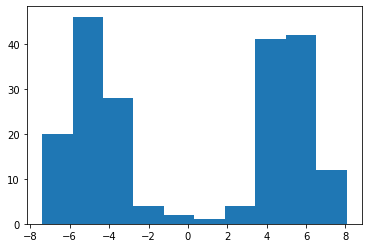

In [6]:
data = np.concatenate([
    tfd.StudentT(5, 0, 1).sample(100) - 5,
    tfd.StudentT(5, 0, 1).sample(100) +5
])
data = np.sort(data)
plt.hist(data)

In [7]:
data = np.sort(data)

In [8]:
from state import State, Prior

In [9]:
prior = Prior(
  alpha = 1.0,
  big_mean = 0,
  big_var = np.var(data) * 5,
  gamma = 0.1,
  jump_a = 1.0,
  jump_b = 5.0,
  var_a = 2.0,
  var_b = 2.0
)

n_atoms = 5

alloc_atoms = np.hstack([np.random.normal(0, np.std(data) * 3, size=(n_atoms, 1)),
                           np.ones((n_atoms, 1)) * 1])
non_alloc_atoms = np.hstack([np.random.normal(0, np.std(data) * 3, size=(n_atoms, 1)),
                               np.ones((n_atoms, 1))])

state = State(
  iter = 0,
  clus = np.random.choice(np.arange(n_atoms), len(data)),
  alloc_atoms = alloc_atoms,
  non_alloc_atoms = non_alloc_atoms,
  alloc_jumps = np.ones(n_atoms),
  non_alloc_jumps = np.ones(n_atoms),
  u = 5,
  latent_centers = np.array([-5, 5]),
  t_vals = np.random.choice(np.arange(2), 2 * n_atoms)
)

In [10]:
for i in range(5000):
    if (i % 100) == 0:
        print("\r{0} / {1}".format(i, 5000), flush=True, end=" ")
    state = algo.step(data, state, prior)

4900 / 5000 

In [11]:
states = [state]
for i in range(1000):
    if (i % 100) == 0:
        print("\r{0} / {1}".format(i, 5000), flush=True, end=" ")
    state = algo.step(data, state, prior)
    states.append(state)

900 / 5000 

In [13]:
import pickle

with open("mcmc_sncp.pickle", "wb") as fp:
    pickle.dump(states, fp)

In [14]:
grid = np.linspace(-15, 15, 1000)


def get_dens(state, grid):
    eval_comps = tfd.Normal(state.alloc_atoms[:, 0], np.sqrt(state.alloc_atoms[:, 1])).prob(grid[:, np.newaxis]) 
    weights = state.alloc_jumps
    weights /= np.sum(weights)
    dens = np.sum(eval_comps * weights, axis=1)
    return dens

In [15]:
from joblib import Parallel, delayed


eval_dens = Parallel(n_jobs=4)(
    delayed(lambda x: get_dens(x, grid))(x) for x in states)

In [16]:
eval_dens = np.vstack(eval_dens)
eval_dens.shape

(1001, 1000)

In [17]:
from bayesmixpy import build_bayesmix, run_mcmc

#build_bayesmix(4)

In [78]:
import os
os.environ["BAYESMIX_EXE"] = "/Users/marioberaha/dev/bayesmix_origin/build/run_mcmc"


dp_params = """
fixed_value {
    totalmass: 1.0
}
"""

mfm_params = """
fixed_value {
    lambda: 4.0
    gamma: 1.0
}
"""

g0_params = """
fixed_values {
    mean: 0.0
    var_scaling: 0.1
    shape: 2.0
    scale: 2.0
}
"""

algo_params = """
    algo_id: "Neal2"
    rng_seed: 20201124
    iterations: 2000
    burnin: 1000
    init_num_clusters: 3
"""

data = np.concatenate([
    tfd.StudentT(3, 0, 1).sample(100) - 5,
    tfd.StudentT(3, 0, 1).sample(100) +5
])
data = np.sort(data)


log_dens_dp, numcluschain_dp, cluschain_dp, bestclus_dp = run_mcmc(
    "NNIG", "MFM", data, g0_params, mfm_params, algo_params, 
    dens_grid=grid, return_clusters=True, return_num_clusters=True,
    return_best_clus=True, out_dir="./")

Running run_mcmc.cc
Creating MemoryCollector
fixed_value {
lambda: 4
gamma: 1
}
Initializing... Done
Running Neal2 algorithm with NNIG hierarchies, MFM mixing...
[============================================================] 100% 0.621s                                                                                                      Done
Computing log-density...
grid: 1000 x 1
Successfully wrote density to ./eval_dens.csv
Successfully wrote number of clusters to ./n_clus.csv
Successfully wrote cluster allocations to ./clus.csv
(Computing mean dissimilarity... Done)
Computing Frobenius norm error...
[================>                                           ] 27% 0.029s    

In [79]:
from scipy.cluster.hierarchy import linkage

def get_psm(clus_chain, sort=True):
    ndata = clus_chain.shape[1]
    out = np.zeros((ndata, ndata))
    for i in range(ndata):
        for j in range(i):
            out[i, j] = out[j, i] = np.mean(clus_chain[:, i] == clus_chain[:, j])
            
    out = out + np.eye(ndata)
    
    if sort:
        y = 1 - out[np.triu_indices(len(out), k=1)]
        Z = linkage(y, method='single', optimal_ordering=True)
        perm = np.ravel(Z[:, :2]).astype(np.int32)
        perm = perm[perm < len(out)]
        out = out[perm][:, perm]
    
    return out

def get_bars_heights(x, clus):
    counts = np.sum(clus == x[:, np.newaxis], axis=1)
    return counts / np.sum(counts)

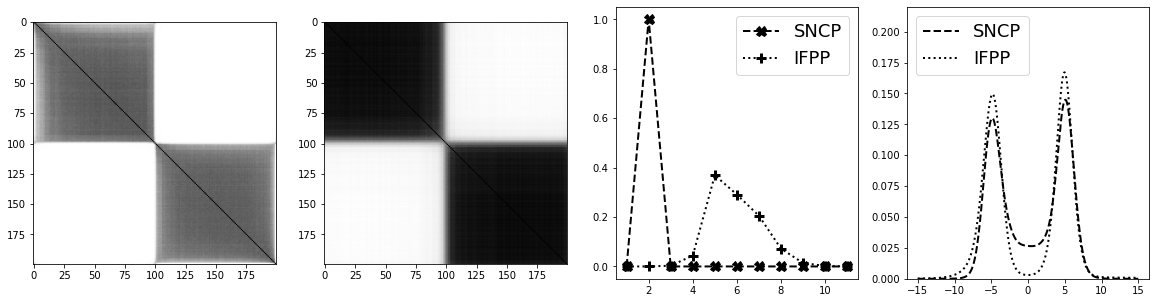

In [80]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

cluschain_sncp = np.vstack([x.t_vals[x.clus] for x in states])
nclus2 = np.array([len(np.unique(x)) for x in cluschain_sncp])

axes[0].imshow(get_psm(cluschain_dp, False), cmap="Greys")

axes[1].imshow(get_psm(cluschain_sncp, False), cmap="Greys")

x = np.arange(1, 12)
h2 = get_bars_heights(x, nclus2)
axes[2].plot(x, h2, "X--", lw=2, markersize=10, color="black", label="SNCP")

h3 = get_bars_heights(x, numcluschain_dp)
axes[2].plot(x, h3, "+:", lw=2, markersize=10, markeredgewidth = 3, color="black", label="IFPP")
axes[2].legend(fontsize=18)

plt.plot(grid, np.mean(eval_dens, axis=0), "--", lw=2, color="black", label="SNCP")
plt.plot(grid, np.mean(np.exp(log_dens_dp), axis=0), ":", lw=2,  color="black", label="IFPP")
axes[3].set_ylim(0, 0.22)
axes[3].legend(fontsize=18, ncol=1)

#plt.savefig("sncp_simulation_new.pdf", bbox_inches="tight")

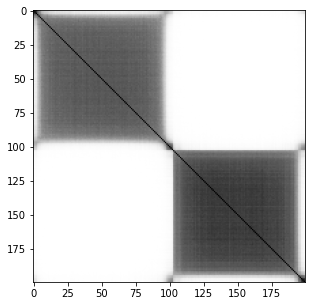

In [59]:
figure = plt.figure(figsize=(5, 5))
plt.imshow(get_psm(cluschain_dp, False), cmap="Greys")
#plt.savefig("sncp_simulation_a.pdf",bbox_inches="tight")

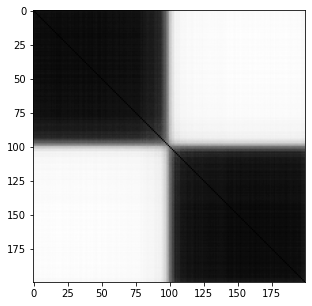

In [58]:
figure = plt.figure(figsize=(5, 5))
plt.imshow(get_psm(cluschain_sncp, False), cmap="Greys")
#plt.savefig("sncp_simulation_b.pdf",bbox_inches="tight")

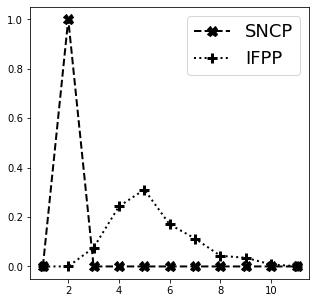

In [57]:
figure = plt.figure(figsize=(5, 5))
x = np.arange(1, 12)
h2 = get_bars_heights(x, nclus2)
plt.plot(x, h2, "X--", lw=2, markersize=10, color="black", label="SNCP")

h3 = get_bars_heights(x, numcluschain_dp)
plt.plot(x, h3, "+:", lw=2, markersize=10, markeredgewidth = 3, color="black", label="IFPP")
plt.legend(fontsize=18)

#plt.savefig("sncp_simulation_c.pdf",bbox_inches="tight")

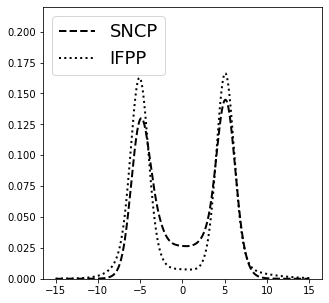

In [56]:
figure = plt.figure(figsize=(5, 5))

plt.plot(grid, np.mean(eval_dens, axis=0), "--", lw=2, color="black", label="SNCP")
plt.plot(grid, np.mean(np.exp(log_dens_dp), axis=0), ":", lw=2,  color="black", label="IFPP")
plt.ylim(0, 0.22)
plt.legend(fontsize=18, ncol=1)

#plt.savefig("sncp_simulation_d.pdf", bbox_inches="tight")

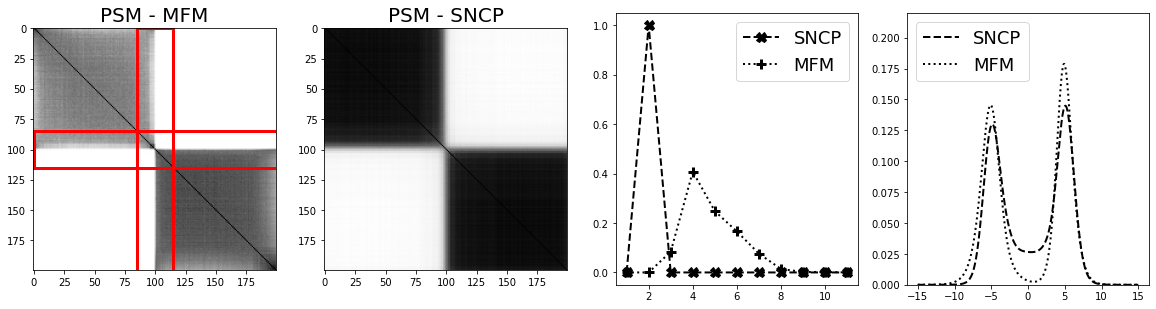

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

cluschain_sncp = np.vstack([x.t_vals[x.clus] for x in states])
nclus2 = np.array([len(np.unique(x)) for x in cluschain_sncp])

axes[0].imshow(get_psm(cluschain_dp, False), cmap="Greys")
axes[0].set_title("PSM - MFM", fontsize=20)

axes[1].imshow(get_psm(cluschain_sncp, False), cmap="Greys")
axes[1].set_title("PSM - SNCP", fontsize=20)

x = np.arange(1, 12)
h2 = get_bars_heights(x, nclus2)
axes[2].plot(x, h2, "X--", lw=2, markersize=10, color="black", label="SNCP")

h3 = get_bars_heights(x, numcluschain_dp)
axes[2].plot(x, h3, "+:", lw=2, markersize=10, markeredgewidth = 3, color="black", label="MFM")
axes[2].legend(fontsize=18)

plt.plot(grid, np.mean(eval_dens, axis=0), "--", lw=2, color="black", label="SNCP")
plt.plot(grid, np.mean(np.exp(log_dens_dp), axis=0), ":", lw=2,  color="black", label="MFM")
axes[3].set_ylim(0, 0.22)
axes[3].legend(fontsize=18, ncol=1)


rect = patches.Rectangle((85, 0), 30, 200, linewidth=3, edgecolor='r', facecolor='none')
axes[0].add_patch(rect)

rect = patches.Rectangle((0, 85), 200, 30, linewidth=3, edgecolor='r', facecolor='none')
axes[0].add_patch(rect)

#plt.savefig("sncp_simulation2.pdf", bbox_inches="tight")

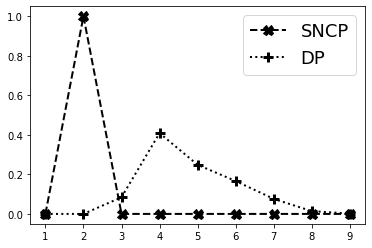

In [34]:
cluschain_sncp = np.vstack([x.clus for x in states])
nclus1 = np.array([len(np.unique(x)) for x in cluschain_sncp])

cluschain_sncp = np.vstack([x.t_vals[x.clus] for x in states])
nclus2 = np.array([len(np.unique(x)) for x in cluschain_sncp])

x = np.arange(1, 10)

h2 = get_bars_heights(x, nclus2)
plt.plot(x, h2, "X--", lw=2, markersize=10, color="black", label="SNCP")

h3 = get_bars_heights(x, numcluschain_dp)
plt.plot(x, h3, "+:", lw=2, markersize=10, markeredgewidth = 3, color="black", label="DP")

plt.legend(fontsize=18)

(array([973.,  20.,   2.,   1.,   2.,   1.,   0.,   0.,   0.,   1.]),
 array([ 0.0564767,  1.9349687,  3.8134606,  5.6919527,  7.5704446,
         9.448936 , 11.327429 , 13.20592  , 15.084413 , 16.962904 ,
        18.841396 ], dtype=float32),
 <BarContainer object of 10 artists>)

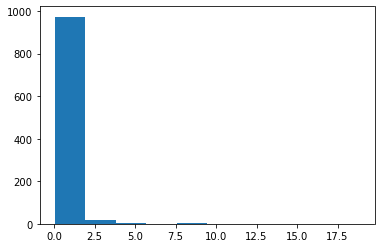

In [24]:
plt.hist(tfd.InverseGamma(2, 0.5).sample(1000))

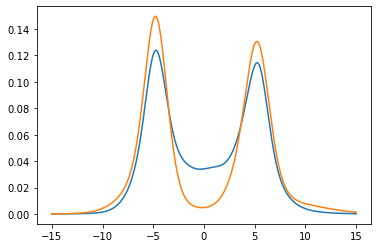

In [15]:
import matplotlib


plt.plot(grid, np.mean(eval_dens, axis=0))
plt.plot(grid, np.mean(np.exp(log_dens_dp), axis=0))

In [16]:
state.latent_centers

array([-5.14512071,  5.71597377])

In [17]:
s = np.argsort(state.alloc_atoms[:, 0])
state.alloc_atoms[s, 0]

array([-6.456843  , -6.14618141, -6.09518381, -6.00341419, -5.8640866 ,
       -5.02466535, -4.88987049, -4.73105988, -4.29361489, -3.72743164,
       -3.44612672, -3.23459374, -3.10120212, -0.39867944,  1.822542  ,
        2.3598752 ,  2.48493775,  3.52113745,  3.73332891,  3.8352795 ,
        4.21767074,  4.33201419,  4.51488802,  4.6606901 ,  4.83476625,
        5.03673615,  5.06399151,  5.23677348,  5.27245313,  5.5912255 ,
        5.7153752 ,  5.93262605,  6.64966741,  7.11014998])

In [18]:
state.alloc_atoms[s, 1]

array([3.20974194, 0.46561709, 1.80607431, 2.2937358 , 0.76031048,
       0.83370209, 0.91479547, 0.60951818, 0.42958596, 1.11966242,
       0.54214841, 0.4083967 , 1.65404833, 2.16630592, 0.91047552,
       0.64433988, 1.04506088, 1.29345959, 1.03513503, 0.45285001,
       0.46985499, 0.67859571, 4.5622257 , 1.84283859, 1.16056577,
       0.5335096 , 0.85136454, 0.37485855, 0.52190463, 0.34884081,
       0.91283781, 0.88131281, 0.38542885, 0.99501346])

In [19]:
state.alloc_atoms[state.clus, 0]

array([-0.39867944, -4.29361489, -3.23459374, -4.29361489, -5.02466535,
       -6.09518381, -4.73105988, -4.29361489, -6.09518381, -6.00341419,
       -4.29361489, -3.23459374, -5.8640866 , -4.73105988, -5.02466535,
        2.3598752 , -6.14618141, -5.8640866 , -5.02466535,  1.822542  ,
       -5.02466535, -5.8640866 , -6.09518381, -4.73105988, -5.02466535,
       -4.29361489, -4.29361489, -5.02466535, -6.456843  , -5.02466535,
       -5.8640866 , -4.29361489, -4.29361489, -6.456843  , -3.10120212,
       -5.02466535, -5.02466535, -3.23459374, -6.09518381, -5.02466535,
       -6.456843  , -4.73105988, -4.88987049, -6.09518381, -4.73105988,
        2.48493775, -6.09518381, -5.02466535, -3.72743164, -5.02466535,
        5.7153752 ,  5.93262605,  7.11014998,  4.6606901 ,  3.73332891,
        3.8352795 ,  4.33201419,  6.64966741,  5.5912255 ,  6.64966741,
        4.83476625,  3.73332891,  4.6606901 ,  7.11014998,  3.73332891,
        4.6606901 ,  4.33201419,  5.7153752 ,  5.23677348,  7.11

In [20]:
np.clip(state.alloc_atoms[state.clus, 0], 0, 1)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])